This notebook is an adaption of ForneyLab.jl demo at https://github.com/biaslab/ForneyLab.jl/blob/master/demo/hidden_markov_model_estimation.ipynb

In [34]:
using DrWatson

@quickactivate :ReactiveMPPaperExperiments

In [35]:
using ForneyLab
using BenchmarkTools
using Random

In [36]:
import Distributions

In [37]:
function rand_vec(distribution::Distributions.Categorical) 
    k = Distributions.ncategories(distribution)
    s = zeros(k)
    s[ rand(distribution) ] = 1.0
    s
end

function normalise(a)
    return a ./ sum(a)
end

normalise (generic function with 1 method)

In [53]:
function generate_data(n_samples, A, B; seed = 124)
    Random.seed!(seed)

    # Initial state
    s_0 = [1.0, 0.0, 0.0] 

    # one-hot encoding of the states and of the observations
    s = Vector{Vector{Float64}}(undef, n_samples) 
    x = Vector{Vector{Float64}}(undef, n_samples)

    s_prev = s_0

    for t in 1:n_samples
        s[t] = rand_vec(Distributions.Categorical(normalise(A * s_prev)))
        x[t] = rand_vec(Distributions.Categorical(normalise(B * s[t])))
        s_prev = s[t]
    end

    return x, s
end

generate_data (generic function with 1 method)

In [121]:
seed = 42

# Number of observations on our model for full graph
n = 250

250

In [122]:
# Transition probabilities (some transitions are impossible)
A = [0.9 0.0 0.1; 0.1 0.9 0.0; 0.0 0.1 0.9] 
# Observation noise
B = [0.9 0.05 0.05; 0.05 0.9 0.05; 0.05 0.05 0.9] 

3×3 Matrix{Float64}:
 0.9   0.05  0.05
 0.05  0.9   0.05
 0.05  0.05  0.9

In [123]:
x_data, s_data = generate_data(n, A, B, seed = seed);

In [124]:
g = FactorGraph()

@RV A ~ Dirichlet(ones(3,3)) # Vague prior on transition model
@RV B ~ Dirichlet([ 10.0 1.0 1.0; 1.0 10.0 1.0; 1.0 1.0 10.0 ]) # Stronger prior on observation model
@RV s_0 ~ Categorical(1.0 / 3.0 * ones(3))

s = Vector{Variable}(undef, n) # one-hot coding
x = Vector{Variable}(undef, n) # one-hot coding

s_t_min = s_0

for t = 1:n
    @RV s[t] ~ Transition(s_t_min, A)
    @RV x[t] ~ Transition(s[t], B)
    
    s_t_min = s[t]
    
    placeholder(x[t], :x, index=t, dims=(3,))
end;

In [125]:
@time begin
    # Generate VMP algorithm with free energy
    pfz = PosteriorFactorization(A, B, [s_0; s], ids=[:A, :B, :S])
    algo = messagePassingAlgorithm(free_energy=true) # Generate algorithm
    source_code = algorithmSourceCode(algo, free_energy=true); # Generate source code for algorithm
    eval(Meta.parse(source_code)); # Load algorithm
end

 86.198745 seconds (9.60 M allocations: 5.550 GiB, 0.58% gc time)


freeEnergy (generic function with 1 method)

In [126]:
@time begin
    # Generate VMP algorithm with free energy
    pfz = PosteriorFactorization(A, B, [s_0; s], ids=[:A, :B, :S])
    algo = messagePassingAlgorithm(free_energy=true) # Generate algorithm
    source_code = algorithmSourceCode(algo, free_energy=true); # Generate source code for algorithm
    eval(Meta.parse(source_code)); # Load algorithm
end

 95.507109 seconds (9.60 M allocations: 5.550 GiB, 0.55% gc time)


freeEnergy (generic function with 1 method)

In [127]:
@time begin
    # Generate VMP algorithm with free energy
    pfz = PosteriorFactorization(A, B, [s_0; s], ids=[:A, :B, :S])
    algo = messagePassingAlgorithm(free_energy=true) # Generate algorithm
    source_code = algorithmSourceCode(algo, free_energy=true); # Generate source code for algorithm
    eval(Meta.parse(source_code)); # Load algorithm
end

 89.291174 seconds (9.60 M allocations: 5.550 GiB, 0.55% gc time)


freeEnergy (generic function with 1 method)

In [128]:
# Because of the global evaluation we cannot robustly perform this benchmark in a loop like we did for Turing and ReactiveMP
# So we change number of observations by hand and perform benchmarks separately 
# ForneyLab model creation time times
# 50 - 18.112930 seconds (1.89 M allocations: 1.086 GiB, 1.48% gc time, 0.04% compilation time)
# 100 - 35.324736 seconds (3.81 M allocations: 2.185 GiB, 0.55% gc time)
# 250 - 89.291174 seconds (9.60 M allocations: 5.550 GiB, 0.55% gc time)
# 500 - 

In [129]:
data = Dict(:x => x_data) # Prepare data dictionary
;

In [130]:
function inference(data)
   # Initial posterior factors
    marginals = Dict{Symbol, ProbabilityDistribution}(
        :A => vague(Dirichlet, (3,3)),
        :B => vague(Dirichlet, (3,3)))

    # Initialize data
    n_its = 15

    # Run algorithm
    F = Vector{Float64}(undef, n_its)
    for i = 1:n_its
        stepS!(data, marginals)
        stepB!(data, marginals)
        stepA!(data, marginals)

        F[i] = freeEnergy(data, marginals)
    end
    marginals, F
end

inference (generic function with 1 method)

In [131]:
@time inference(data);

369.438220 seconds (9.80 M allocations: 456.601 MiB, 0.12% gc time, 99.79% compilation time)


In [132]:
# ForneyLab compilation time
# 50 - 10.539947 seconds (2.10 M allocations: 104.189 MiB, 0.24% gc time, 99.61% compilation time)
# 100 - 49.138086 seconds (4.02 M allocations: 191.916 MiB, 0.14% gc time, 99.78% compilation time)
# 250 - 369.438220 seconds (9.80 M allocations: 456.601 MiB, 0.12% gc time, 99.79% compilation time)

In [133]:
@time inference(data);

  0.942113 seconds (1.15 M allocations: 80.665 MiB, 73.97% gc time)


In [134]:
@time inference(data);

  0.753549 seconds (1.15 M allocations: 80.665 MiB, 68.04% gc time)


In [135]:
@btime inference($data);

  217.223 ms (1154113 allocations: 80.67 MiB)


In [120]:
# ForneyLab execution times
# 50 - 33.908 ms (236110 allocations: 16.40 MiB)
# 100 - 84.347 ms (465613 allocations: 32.48 MiB)
# 250 - 217.223 ms (1154113 allocations: 80.67 MiB)

In [55]:
inferred = step!(data) # Execute inference
marginals = map(i -> inferred[Symbol(:x_, i)], 1:n_smoothing) 
;

In [56]:
# ForneyLab execution times
# 50 - 1.482 ms (19742 allocations: 2.07 MiB)
# 100 - 3.329 ms (39642 allocations: 4.14 MiB)
# 250 - 8.189 ms (99600 allocations: 10.39 MiB)

In [13]:
using Plots

In [58]:
using Plots

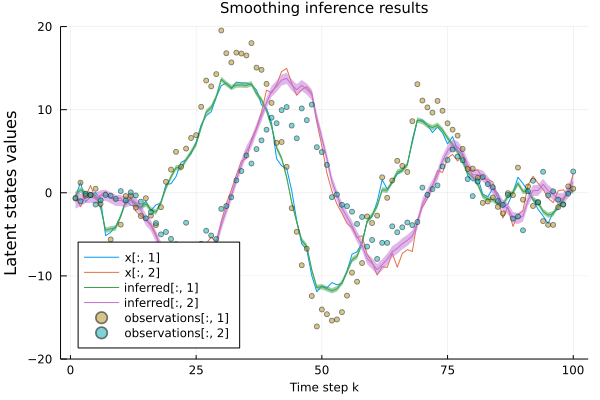

In [59]:
begin
    local reshape_data = (data) -> transpose(reduce(hcat, data))
    
    local ylimit = (-20, 20)

    local x_label = [ "x[:, 1]" "x[:, 2]" ]
    local y_label = [ "observations[:, 1]" "observations[:, 2]" ]
    local i_label = [ "inferred[:, 1]" "inferred[:, 2]" ]

    local x_reshaped = x_data |> reshape_data
    local y_reshaped = y_data |> reshape_data

    local x_inferred_means = mean.(marginals) |> reshape_data
    local x_inferred_stds  = var.(marginals) |> reshape_data

    local p = plot(
        title = "Smoothing inference results", titlefontsize = 10,
        xlabel = "Time step k", xguidefontsize = 8,
        ylabel = "Latent states values", yguidefonrsize = 8
    )
    local range = 1:n_smoothing

    p = plot!(p, range, x_reshaped, label = x_label)
    p = plot!(p, range, x_inferred_means, ribbon = x_inferred_stds, label = i_label)
    p = scatter!(p, range, y_reshaped, ms = 3, alpha = 0.5, label = y_label)
    p = plot!(p, legend = :bottomleft, ylimit = ylimit) 
    
    plot(p)
end